In [ ]:
!pip install recogym

## Bandit Feedback - Organic Best of vs Bandit Best of

In this notebook we use the bandit signal for the first time, in the simplest possible way.  We compare how a recommender system that always makes the most popular organic product as a recommender with a recommender system that always makes the most popular bandit product.

We see that there can be differences in behaviour.

In [1]:
import gym, recogym
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

ABTestNumberOfUsers=5000
NumberOfProducts=10
NumberOfSamples = 20
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=10
env_1_args['sigma_mu_organic'] = 2
env_1_args['sigma_omega']=0
env_1_args['random_seed'] = 42
env_1_args['num_products'] = NumberOfProducts
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 3
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [2]:
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym import Configuration

organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
            **organic_user_count_args,
            **env_1_args,
            'select_randomly': True,
        }))

In [3]:
data = env.generate_logs(ABTestNumberOfUsers)

In [4]:
data[:10]

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,0.0,organic
1,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,0,NaN,bandit
2,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,0,NaN,bandit
3,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,0,NaN,bandit
4,NaN,NaN,NaN,None,0,1,1.0,organic
5,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,1,NaN,bandit
6,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,1,NaN,bandit
7,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,1,NaN,bandit
8,NaN,NaN,NaN,None,4,1,4.0,organic
9,NaN,NaN,NaN,None,5,1,6.0,organic


Here is the data the following columns are present:
* **`t`**—_`Time`_. Currently, _`Time`_ reflects the order of _`Events`_ but it does **not** represent the notion of the time in a physical sense.
* **`u`**—_`User`_.
* **`z`**—_`Event Type`_. There are two types of _`Events`_: _Organic_ and _Bandit_.
* **`v`**—_`View`_. The column shows which _`Product`_ was shown to a _`User`_ in an _Organic_ _`Event`_.
* **`a`**—_`Action`_. Currently, _`Action`_ is a _`Product`_ that was provided to a _`User`_ during a _Bandit_ _`Event`_.
* **`c`**—_`Click`_. This is a _Reward_ for an _`Action`_ provided by the _`Agent`_.
* **`ps`**—Probability of selecting a particular _`Action`_.

**Note #1:** _`Time`_, _`User`_, _`Views`_, and _`Actions`_ **all** them start with _`0`_.

**Note #2:** For any _`User`_, _Organic_ _`Event`_ _**always**_ precedes a _Bandit_ _`Event`_.

## Data Analysis
Let's analyse these histograms:
* _Actions per Product_
* _Clicks per Product_
* _Views per Product_.

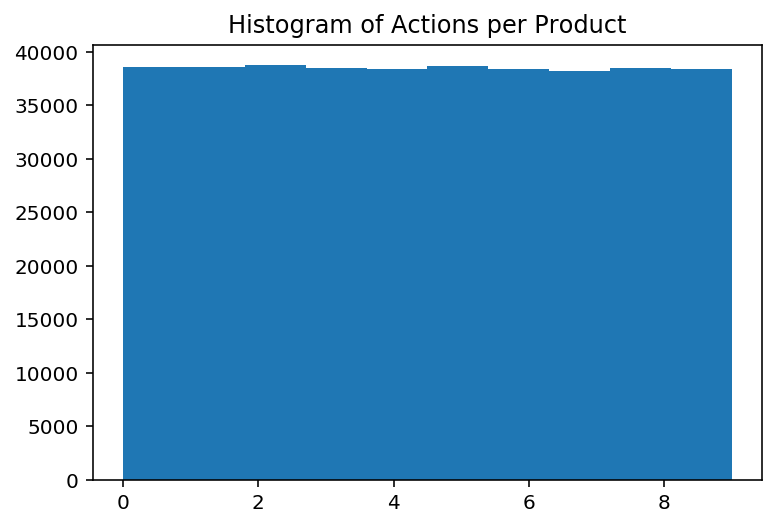

In [5]:
_, ax = plt.subplots()
ax.set_title('Histogram of Actions per Product')

ax.hist(data[data['z'] == 'bandit']['a'])
plt.show()

It is evident that all _`Actions`_ are _*evenly*_ distributed.
That is an expected behaviour because *all* _`Actions`_ are randomly applied for all _Bandit_ _`Events`_.  This is not typical behaviour (usually actions are personalised not random) and we will relax this assumption later in the course.

Clicks:  [419. 346. 487. 337. 384. 507. 372. 384. 475. 503.]


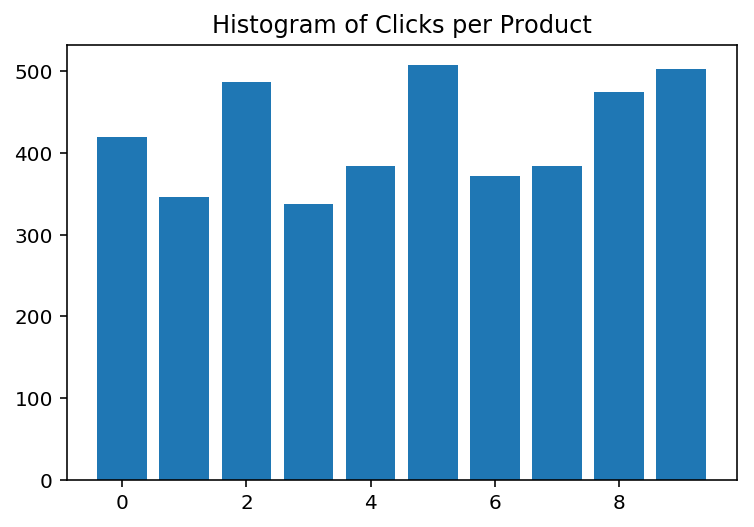

In [6]:
clicks = np.zeros(NumberOfProducts)
bandits = data[data['z'] == 'bandit']
for product_id in range(NumberOfProducts):

    clicks[product_id] = # code here
    
print("Clicks: ", clicks)

_, ax = plt.subplots()
ax.set_title('Histogram of Clicks per Product')

ax.bar(range(NumberOfProducts), clicks)
plt.show()

We can estimate a click through rate for each recommendation by dividing the number of times we obtained a click by the number of impressions.  This produces the following "bandit best of":

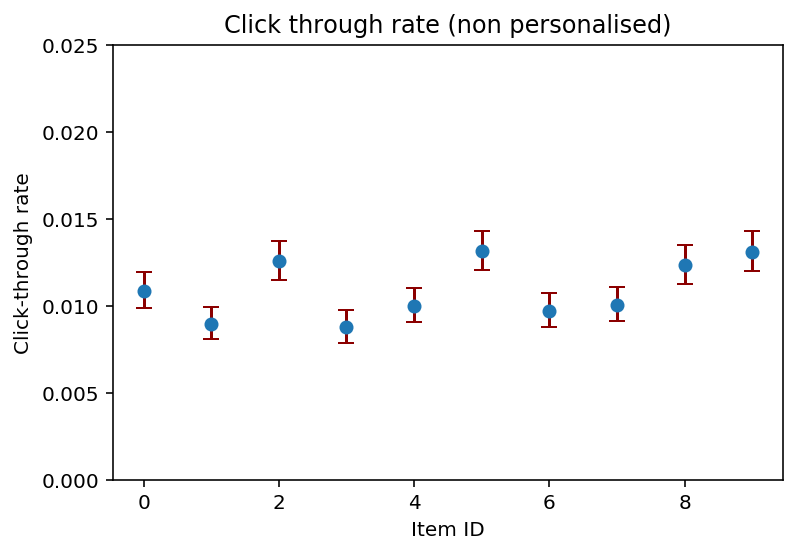

In [7]:
from scipy.stats.distributions import beta

clicks = np.zeros(NumberOfProducts)
impressions = np.zeros(NumberOfProducts)
lower_errors = np.zeros(NumberOfProducts)
upper_errors = np.zeros(NumberOfProducts)
bandits = data[data['z'] == 'bandit']
for product_id in range(NumberOfProducts):

    clicks[product_id] = # code here
    impressions[product_id] = # code here

    # Compute expected value according to a beta distribution
    expected_value = beta.ppf(0.500, clicks[product_id] + 1, impressions[product_id] - clicks[product_id] + 1)
    # Compute a confidence interval
    lower_bound = beta.ppf(0.025, clicks[product_id] + 1, impressions[product_id] - clicks[product_id] + 1)
    upper_bound = beta.ppf(0.975, clicks[product_id] + 1, impressions[product_id] - clicks[product_id] + 1)
    # Save difference as error
    lower_errors[product_id] = expected_value - lower_bound
    upper_errors[product_id] = upper_bound - expected_value
    

_, ax = plt.subplots()
ax.set_title('Click through rate (non personalised)')

ax.errorbar(range(NumberOfProducts),
            clicks/impressions,
            yerr = (lower_errors, upper_errors),
            fmt = 'o',
            ecolor = 'darkred',
            capsize = 4)

plt.ylim([0,0.025])
plt.xlabel('Item ID')
plt.ylabel('Click-through rate')
plt.show()

The non-personalised click through rate can be uses as a non-personalised agent.  This will be our first likelihood based agent.

In [8]:
from collections import defaultdict

from recogym.agents.abstract import Agent

class GreedySingleActionAgent(Agent):
    def __init__(self, preferred_action, config = Configuration({'num_products': 10})):
        super(GreedySingleActionAgent, self).__init__(config)
        self.preferred_action = preferred_action
        
    def act(self, observation, reward, done):
        prob = np.zeros(self.config.num_products)
        prob[self.preferred_action] = 1.
        return {
            **super().act(observation, reward, done),
            **{
                'a': self.preferred_action,
                'ps': prob[self.preferred_action],
                'ps-a': prob,
            },
        }

In [9]:
# Initialise bandit
top_ctr_item = # code here
print('The Greedy-Bandit agent will always take action {0}'.format(top_ctr_item))
greedy_bandit = GreedySingleActionAgent(top_ctr_item, Configuration(env_1_args))

The Greedy-Bandit agent will always take action 5


The ads that in a non-personalised sense attracts the most clicks is not in general the same as a product that is often viewed organically, to see this we can plot the organic views:

Views:  [11512.  4417.  1424.  8863. 25520. 13516.  3378.  9001.  4898. 23705.]


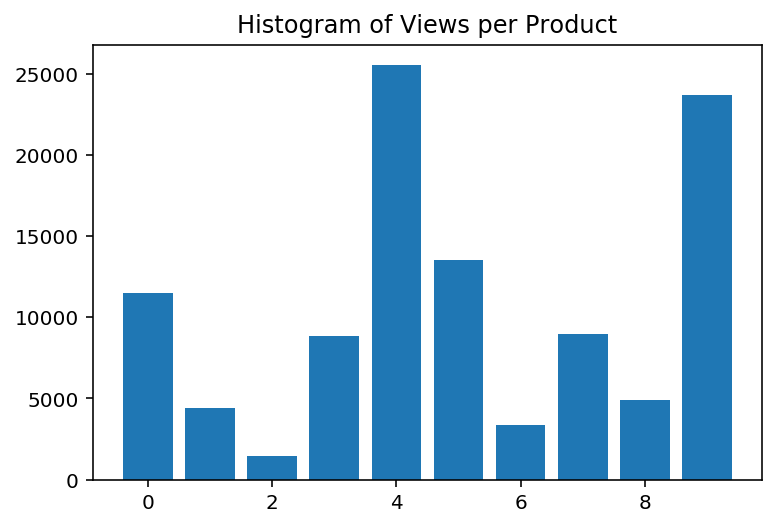

In [10]:
organics = data[data['z'] == 'organic']

views = np.zeros(NumberOfProducts)
for product_id in range(NumberOfProducts):
    views[product_id] = organics[organics['v'] == product_id].shape[0]

print("Views: ", views)

_, ax = plt.subplots()
ax.set_title('Histogram of Views per Product')

ax.bar(range(NumberOfProducts), views)
plt.show()

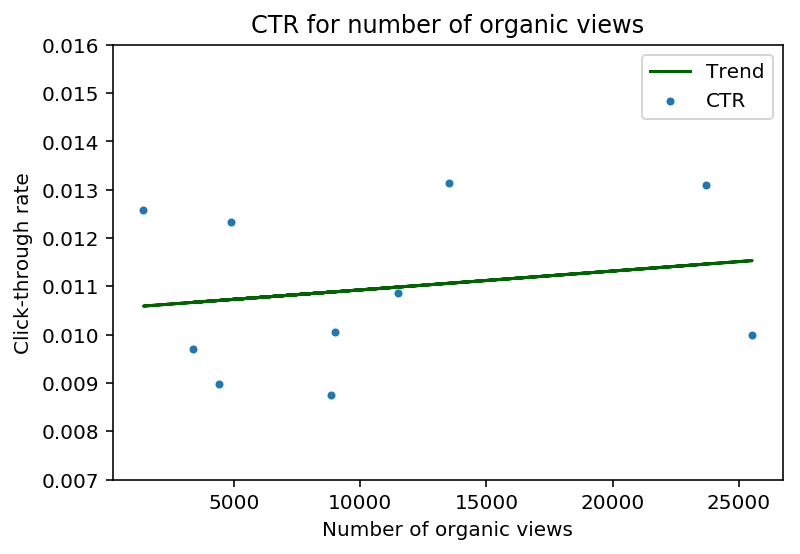

In [11]:
# Plot number of organic views on x-axis and CTR on y-axis
CTR = np.array(clicks)/np.array(impressions)


_, ax = plt.subplots()
ax.set_title('CTR for number of organic views')

ax.scatter(views, CTR, marker = '.', label = 'CTR')

z = np.polyfit(views, CTR, 1)
p = np.poly1d(z)
ax.plot(views, p(views), color = 'darkgreen', label = 'Trend')

plt.xlabel('Number of organic views')
plt.ylabel('Click-through rate')

plt.gca().set_ylim([0.007,0.016])
plt.legend()
plt.show()

While there may be a relationship between popular products and high click through rate it is certainly not guaranteed.  This fact underlies the need to use bandit feedback.  Here we will develop our final organic agent as an organic best of to hammer home this point.

In [12]:
# Initialise bandit
top_viewed_item = # code here
print('The organic-best-of agent will always take action {0}'.format(top_viewed_item))
greedy_organic = GreedySingleActionAgent(top_viewed_item, Configuration(env_1_args))

The organic-best-of agent will always take action 4


In [13]:
from datetime import datetime
from recogym.evaluate_agent import verify_agents, plot_verify_agents

print('Starting A/B-testing at {0}'.format(datetime.now()))
result = verify_agents(env,
                       10000,
                       {'Greedy-Bandit': greedy_bandit,
                        'Greedy-Organic': greedy_organic})
print('Finished A/B-testing at {0}'.format(datetime.now()))

Starting A/B-testing at 2019-06-20 15:57:03.413166
Finished A/B-testing at 2019-06-20 15:59:49.649804


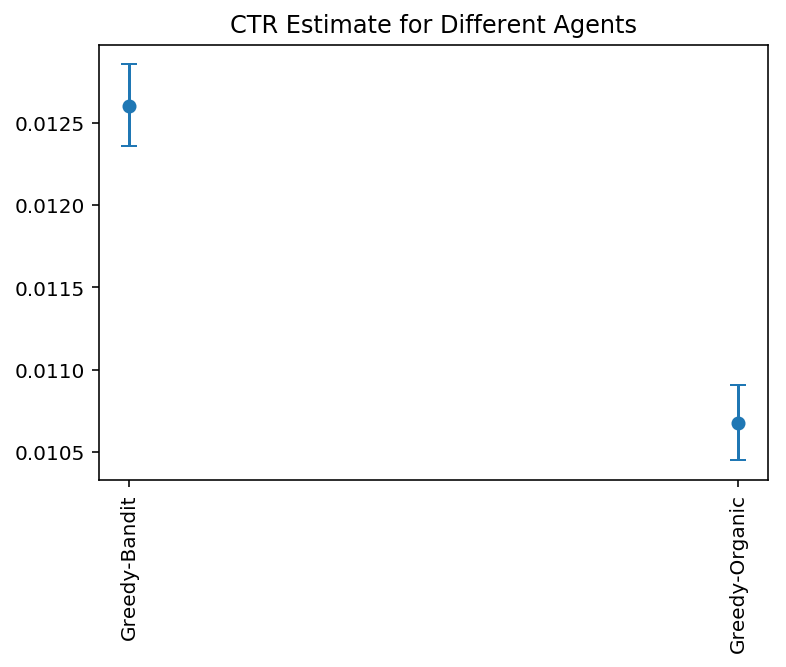

In [14]:
fig = plot_verify_agents(result)
plt.show()